In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [2]:
def plot_actual_vs_pred(actual, pred, title, levels = [25,50,100]):
    gas = ['NO', 'NO_2', 'NH_3']
    fig, axs = plt.subplots(1,3, figsize=(20, 20/3), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=30)
    for i, ax in enumerate(axs.flat):
        ax.scatter(actual[:,i], pred[:,i], color = 'red')
        ax.set_title(f'${gas[i]}$', fontsize = 15)
        ax.set_ylabel('Predicted', fontsize = 20)
        ax.set_xlabel('Actual', fontsize=20)
        #ax.set_ylim((0,150))
        #ax.set_xlim((0,150))
        ax.axline([0, 0], [1, 1], color = 'blue', linestyle=':')
        
        plt.xticks(levels)
    plt.show()

# Reading data

In [3]:
# Reading data
dummy = pd.read_csv('../data/dummy.csv')
dummy.head()

,Unnamed: 0,NO2,NO,NH3,slope0,slope1,slope2,slope3,slope4,slope5,...,avg40,avg41,avg42,avg43,avg44,avg45,avg46,avg47,avg48,avg49
0,mix0,50,100,25,0.000261,0.000347,0.000378,0.000342,0.000255,0.000254,...,1.788009e-07,-0.000001,-1.270353e-06,-1.920155e-06,-1.117044e-06,-6.934313e-07,8.882652e-08,4.687770e-07,2.236791e-07,-1.484270e-07
1,mix1,100,25,100,0.000244,0.000334,0.000371,0.000342,0.000256,0.000257,...,-6.433617e-07,0.000002,2.373382e-06,1.108367e-06,1.701933e-06,7.345070e-07,-3.755813e-07,-6.079087e-08,-4.277830e-07,4.461413e-07
2,mix2,25,100,50,0.000258,0.000343,0.000374,0.000340,0.000256,0.000254,...,-3.621577e-06,-0.000003,-9.317178e-07,7.781265e-07,-3.612217e-08,-9.233391e-07,-1.310730e-07,5.655704e-07,6.936261e-08,-1.512365e-07
3,mix3,50,25,100,0.000249,0.000341,0.000375,0.000341,0.000261,0.000261,...,2.510960e-06,0.000003,1.811447e-06,7.319652e-08,4.306713e-07,6.000130e-08,-3.678943e-07,4.973391e-08,-5.947913e-08,-2.831873e-06
4,mix4,100,100,25,0.000256,0.000340,0.000371,0.000332,0.000252,0.000251,...,3.064678e-06,0.000003,9.766817e-07,-7.697217e-07,-3.745022e-07,-4.271674e-07,4.307696e-08,-7.368087e-08,-2.749222e-07,-2.755930e-06


# Linear Regression

In [4]:
# Dependent Variables - gas concentrations
y = np.asarray(dummy.iloc[:, 1:4])

# Independent variables - shape features
X = np.asarray(dummy.iloc[:, 4:])

In [5]:
# Train (train+test) / validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
steps = [('scaler', StandardScaler()),
         ('poly', PolynomialFeatures()),
         ('linreg', LinearRegression())]

params = [{'poly__degree':list(range(1,5))}]

lr_pipe = Pipeline(steps)

lr_search = GridSearchCV(lr_pipe,
                         params,
                         scoring = 'neg_root_mean_squared_error',
                         n_jobs = -1,
                         return_train_score=True,
                         cv = LeaveOneOut())

# Fitting to training data (test is in LOO)
lr_search.fit(X_train, y_train)
print(lr_search.best_params_)
print(lr_search.best_score_)

{'poly__degree': 2}
-48.962804496552174


In [7]:
# Testing on unseen validation data
lr_y_pred = lr_search.best_estimator_.predict(X_val)

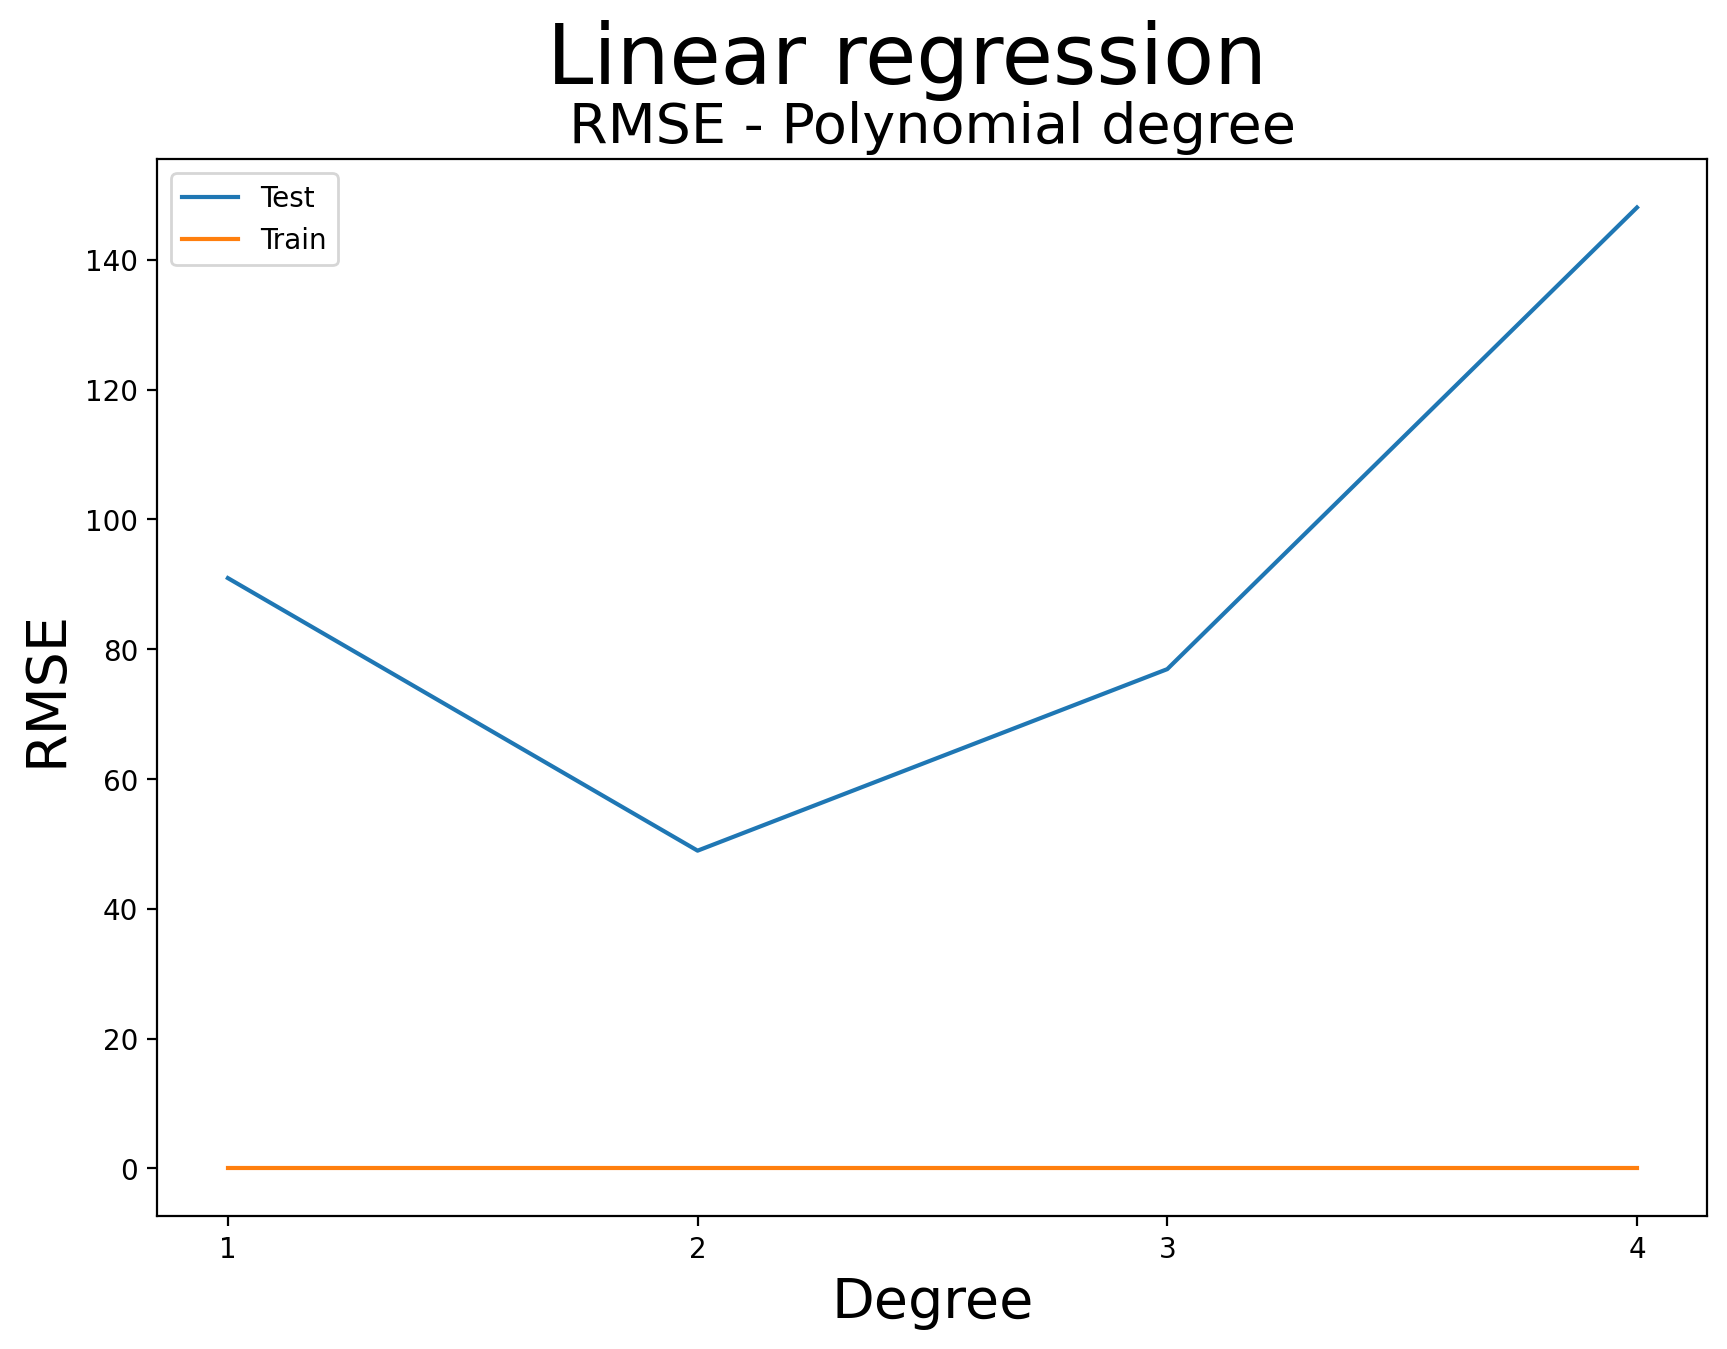

In [8]:
# Scores
test_scores = lr_search.cv_results_['mean_test_score'] * -1 
train_scores = lr_search.cv_results_['mean_train_score'] * -1

# Plotting
plt.figure(figsize=(10, 7), dpi=200)
plt.plot([1, 2, 3, 4] ,test_scores, label='Test')
plt.plot([1, 2, 3, 4], train_scores, label='Train')
plt.suptitle('Linear regression', fontsize=30)
plt.title('RMSE - Polynomial degree', fontsize = 20)
plt.xlabel('Degree', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks([1, 2, 3, 4])
plt.legend(loc='best')
plt.show()

# Principal Components Regression - PCR

In [9]:
steps = [('scaler', StandardScaler()),
         ('PCA', PCA()),
         ('poly', PolynomialFeatures()),
         ('linreg', LinearRegression())]

params = [{'PCA__n_components':list(range(1,14)),
           'poly__degree':list(range(1,4))}]

pcr_pipe = Pipeline(steps)

pcr_search = GridSearchCV(pcr_pipe,
                      params,
                      scoring = 'neg_root_mean_squared_error',
                      n_jobs = -1,
                      return_train_score=True,
                      cv = LeaveOneOut())
pcr_search.fit(X_train, y_train)
print(pcr_search.best_params_)
print(pcr_search.best_score_)

{'PCA__n_components': 3, 'poly__degree': 1}
-25.92872736485713


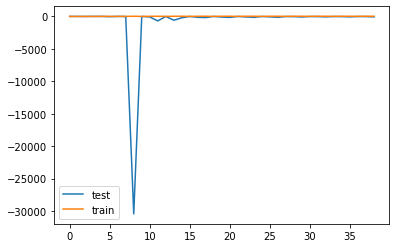

In [10]:
test_scores = pcr_search.cv_results_['mean_test_score'] 
train_scores = pcr_search.cv_results_['mean_train_score']

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [11]:
# Testing on unseen validation data
pcr_y_pred = pcr_search.best_estimator_.predict(X_val)

# Partial Least Squares Regression - PLSR

In [12]:
plsr_steps = [('poly', PolynomialFeatures()),
              ('PLSR', PLSRegression())]


plsr_params = [{'PLSR__n_components':list(range(1,14)),
                'poly__degree':list(range(1,4))}]

plsr_pipe = Pipeline(plsr_steps)

plsr_search = GridSearchCV(plsr_pipe,
                           plsr_params,
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs = -1,
                           return_train_score=True,
                           cv = LeaveOneOut())

plsr_search.fit(X_train, y_train)
print(plsr_search.best_params_)
print(plsr_search.best_score_)

{'PLSR__n_components': 2, 'poly__degree': 1}
-26.27037862487519


In [13]:
# Testing on unseen validation data
plsr_y_pred = plsr_search.best_estimator_.predict(X_val)

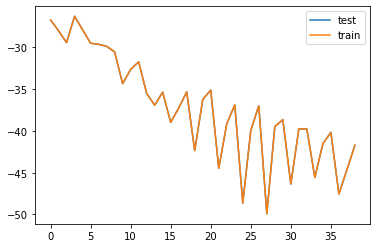

In [16]:
test_scores = plsr_search.cv_results_['mean_test_score'] 
train_scores = plsr_search.cv_results_['mean_test_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

# Ridge Regression

# Plotting

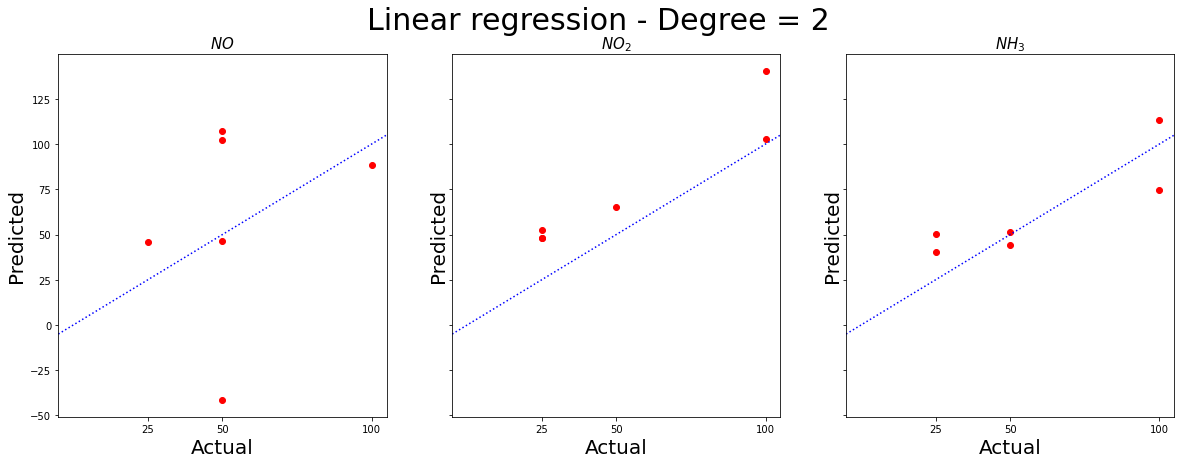

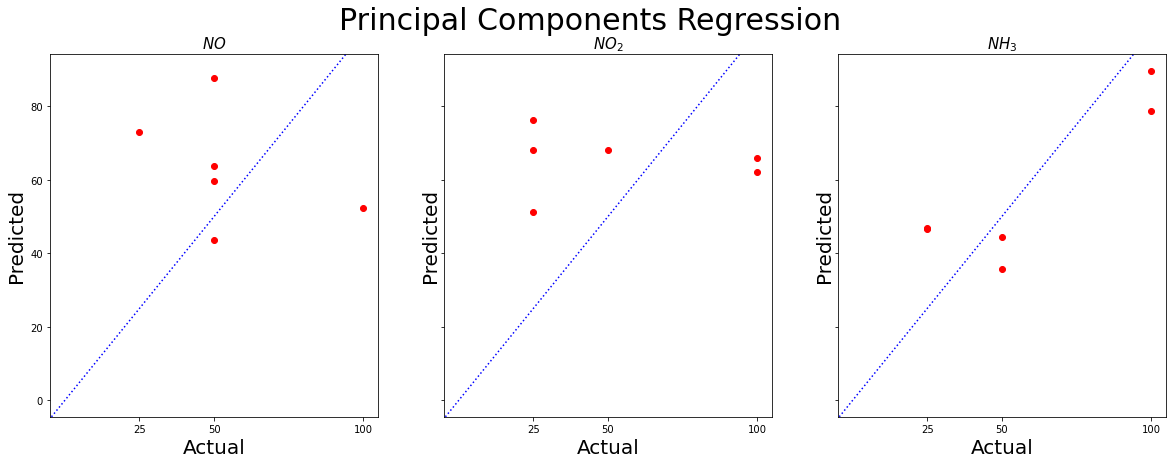

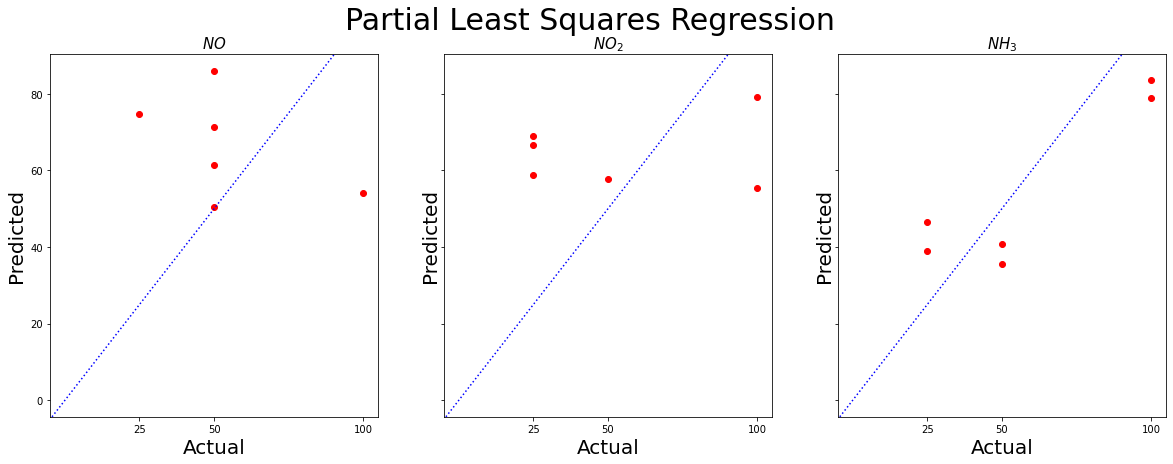

In [17]:
plot_actual_vs_pred(y_val, lr_y_pred, 'Linear regression - Degree = 2')

plot_actual_vs_pred(y_val, pcr_y_pred, 'Principal Components Regression')

plot_actual_vs_pred(y_val, plsr_y_pred, 'Partial Least Squares Regression')
